In [1]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


'/home/guilherme/scantensus-sdy'

In [2]:
from pathlib import Path

from src.utils.matt_heatmap import UnityMakeHeatmaps
from src.pressure_damping.pretransformations import PretransformationsModule
from src.pressure_damping.curve_dataset import CurveDataset

import numpy as np
import torch
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive

import PIL
import PIL.Image

IMAGE_SHAPE = (512, 512)

dataset = CurveDataset(
    projects=['imp-coro-shunshin-sdy-flow-good'],
    output_shape=IMAGE_SHAPE,
    firebase_certificate=Path('.firebase.json')
)

2024-01-18 12:23:13.388 | INFO     | src.pressure_damping.curve_dataset:__init__:110 - Loaded 1 results containing 90 curves.


In [3]:
res = dataset[0]

image = res['image']
T = res['transform_matrix']
width_shift = res['width_shift']
height_shift = res['height_shift']
labels = res['labels']

image.shape

/home/guilherme/scantensus-sdy/src/pressure_damping/curve_dataset.py:190: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1508.)
  img_bytes = torch.frombuffer(r.content, dtype=torch.uint8)
2024-01-18 12:23:13.399 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded


torch.Size([1, 512, 512])

2024-01-18 12:25:07.321 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded
/tmp/ipykernel_63358/4032709584.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet_map = cm.get_cmap('jet')


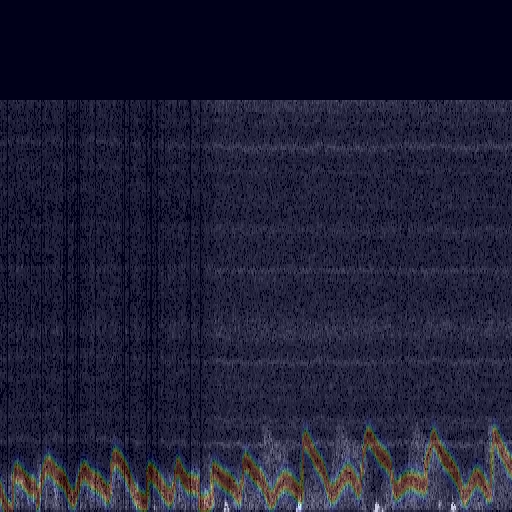

In [10]:
def plot_image_with_heatmap(index: int):
    res = dataset[index]

    image = res['image']
    T = res['transform_matrix']
    width_shift = res['width_shift']
    height_shift = res['height_shift']
    raw_labels = res['labels']

    heatmap_gen = UnityMakeHeatmaps(
        keypoint_names=['curve-flow'],
        image_crop_size=(dataset.crop_shape[0], dataset.crop_shape[1]),
        image_out_size=(dataset.output_shape[0], dataset.output_shape[1]),
    )

    heatmaps, weights = heatmap_gen.forward(
        label_data=[raw_labels],
        label_height_shift=[height_shift],
        label_width_shift=[width_shift],
        transform_matrix=[T]
    )

    # rendering stuff

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8))

    SHOW_H = dataset.output_shape[0] // 1
    SHOW_W = dataset.output_shape[1] // 1

    resized_heatmap = torchvision.transforms.Resize((SHOW_H, SHOW_W))(heatmap_jetted)
    original_image = torchvision.transforms.Resize((SHOW_H, SHOW_W))(torchvision.transforms.ToPILImage()(image))

    resized_heatmap = resized_heatmap.convert('RGBA')
    original_image = original_image.convert('RGBA')

    blended = PIL.Image.blend(original_image, resized_heatmap, alpha=0.2)

    return blended

plot_image_with_heatmap(0)

In [9]:
def new_plot_image_with_heatmap(index: int):
    image, raw_labels, T = dataset[index]

    pretransform = PretransformationsModule(
        keypoint_names=['curve-flow'],
        image_crop_size=IMAGE_SHAPE,
        image_out_size=IMAGE_SHAPE
    )

    images, heatmaps, weights = pretransform.forward(
        label_data=[raw_labels],
        images=image.unsqueeze(0),
        dataset_transform_matrices=[T]
    )

    heatmap = heatmaps[0].squeeze()
    jet_map = cm.get_cmap('jet')

    heatmap_jetted = PIL.Image.fromarray((jet_map(heatmap.numpy()) * 255).astype(np.uint8)).convert('RGBA')
    heatmap_jetted = heatmap_jetted.resize((IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

    image = torchvision.transforms.ToPILImage()(images.to(torch.uint8).squeeze()).convert('RGBA')

    return image, heatmap_jetted

image, heatmap = new_plot_image_with_heatmap(0)

2024-01-18 12:24:55.012 | DEBUG    | src.pressure_damping.curve_dataset:read_image_into_t:193 - http://cardiac5.ts.zomirion.com:50601/scantensus-database-png-flat/01/03/9a/01-039a5b730e6fa2320f23fa1518b15107329b3d83c011aeaaae44ae35eadfb29c-0004.png: Successfully loaded


ValueError: too many values to unpack (expected 3)

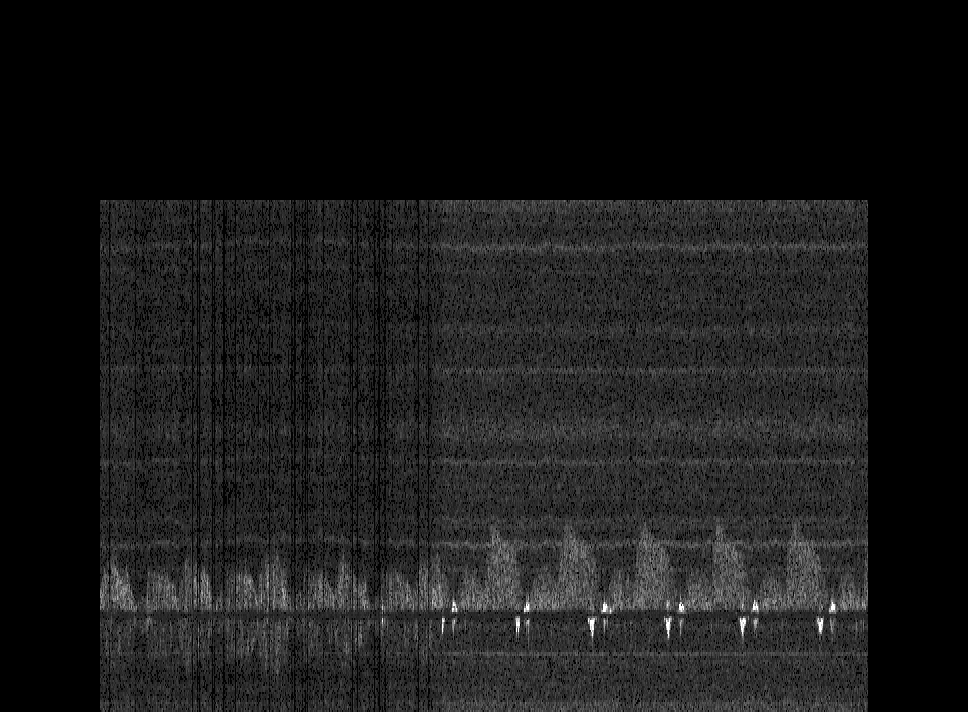

In [7]:
#PIL.Image.blend(image, heatmap, alpha=0.5)
image